In [1]:
print("Gonna Start the cw, bless me!!")

Gonna Start the cw, bless me!!


# DataSet into a Pandas DataFrame

In [2]:
import pandas as pd
import os

print("Just getting the file and checking how it works and what the file looks like\n")

# Paths
file_path = '../UniqueGiftsLTDProject/online_retail_II.xlsx'
csv_path = '../UniqueGiftsLTDProject/online_retail_II_full.csv'

# ✅ Read the full Excel file
df = pd.read_excel(file_path)  # remove nrows to load all rows

# ✅ Save as CSV
df.to_csv(csv_path, index=False)
print(f"File saved as CSV at: {csv_path}")

# ✅ Read CSV back
df_csv = pd.read_csv(csv_path)

# Optional: force correct types like your friend did
df_csv['Invoice'] = df_csv['Invoice'].astype(str)
df_csv['InvoiceDate'] = pd.to_datetime(df_csv['InvoiceDate'], errors='coerce')

# Display first 5 rows and info like your friend
df_csv.head()
print("\nDataframe Info:")
df_csv.info()



Just getting the file and checking how it works and what the file looks like

File saved as CSV at: ../UniqueGiftsLTDProject/online_retail_II_full.csv

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [3]:
print("Column Types And Missing Count \n")
df.info()



Column Types And Missing Count 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [4]:

print("Getting Status as a table \n")

df.describe()


Getting Status as a table 



,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


In [5]:
print("counts missing values in each column \n")
df.isnull().sum()

counts missing values in each column 



Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [6]:
# Handle dupplicates and missing values
print(df.duplicated().sum())

df.drop_duplicates(inplace=True)

print(df.duplicated().sum())

# Count missing Customer ID
missing_customer_id = df['Customer ID'].isna().sum()
print(f"Number of rows missing Customer ID: {missing_customer_id}")


df.dropna(subset=['Customer ID'], inplace=True)
df.isnull().sum()


6865
0
Number of rows missing Customer ID: 107833


Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [7]:
# Clean Transactional Data

# Filter cancelled orders (Invoice starting with 'C')
cancelled_orders = df[df['Invoice'].astype(str).str.startswith('C')]

# Number of cancelled orders
print(f"Number of cancelled orders: {cancelled_orders.shape[0]}")

# Optional: total quantity or value of cancelled orders
total_cancelled_quantity = cancelled_orders['Quantity'].sum()
total_cancelled_value = (cancelled_orders['Quantity'] * cancelled_orders['Price']).sum()

print(f"Total cancelled quantity: {total_cancelled_quantity}")
print(f"Total cancelled value: {total_cancelled_value}")

# Keep only non-cancelled orders
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Check
print(f"Number of rows after removing cancelled orders: {df.shape[0]}")


Number of cancelled orders: 9816
Total cancelled quantity: -211856
Total cancelled value: -483378.16000000003
Number of rows after removing cancelled orders: 400947


In [8]:
# Creating Column - TotalPrice

df['TotalPrice'] = df['Quantity'] * df['Price']

print(df.shape)
df.head()


(400947, 9)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


# Charttttt Thinggggggggggg

/tmp/ipykernel_6523/1443445571.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.resample('M', on='InvoiceDate')['Sales'].sum()


Index Values =>  DatetimeIndex(['2009-12-31', '2010-01-31', '2010-02-28', '2010-03-31',
               '2010-04-30', '2010-05-31', '2010-06-30', '2010-07-31',
               '2010-08-31', '2010-09-30', '2010-10-31', '2010-11-30',
               '2010-12-31'],
              dtype='datetime64[ns]', name='InvoiceDate', freq='ME')
Values =>  [ 683504.01   555802.672  504558.956  696978.471  591982.002  597833.38
  636371.13   589736.17   602224.6    829013.951 1033112.01  1166460.022
  310656.37 ]


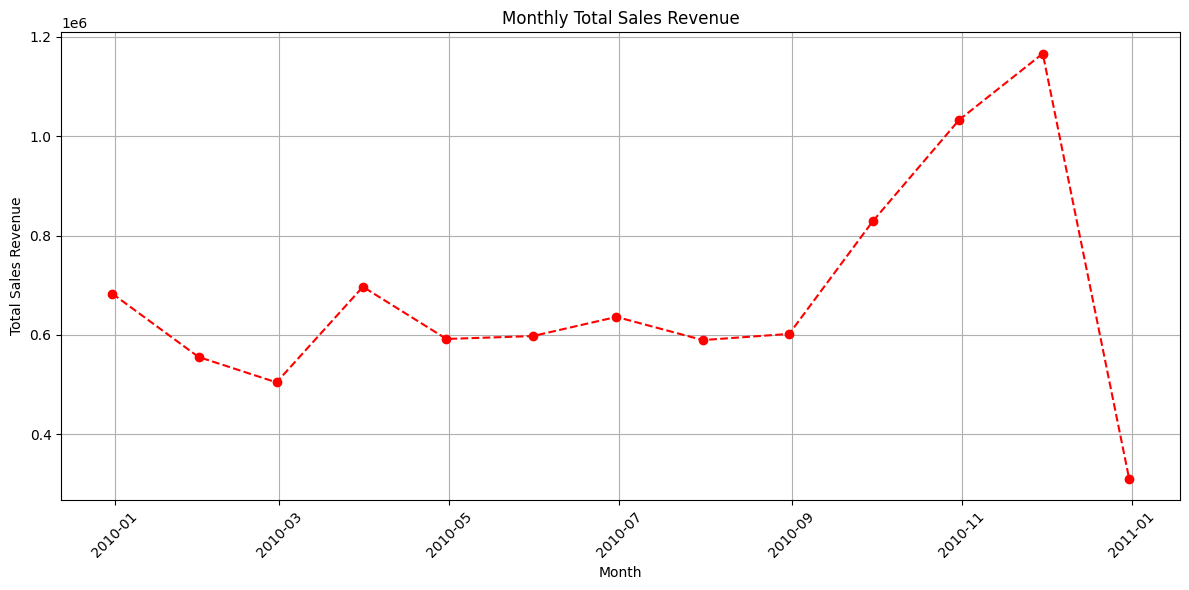

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Make sure InvoiceDate is datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Remove cancelled orders (Invoice starting with 'C') if not already removed
# df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Create a 'Sales' column
df['Sales'] = df['Quantity'] * df['Price']

# Group by month
monthly_sales = df.resample('M', on='InvoiceDate')['Sales'].sum()

# Plotting
plt.figure(figsize=(12,6)) # plt.figure() → creates a new figure (basically a blank canvas)
plt.plot(monthly_sales.index, monthly_sales.values, marker='o', linestyle='--', color='red')

print("Index Values => ",monthly_sales.index)
print("Values => ",monthly_sales.values)

plt.title('Monthly Total Sales Revenue')
plt.xlabel('Month')
plt.ylabel('Total Sales Revenue')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Month
1     25.898265
2     21.897359
3     21.929285
4     22.060893
5     21.174986
6     20.734780
7     22.133920
8     23.135789
9     24.289178
10    21.202915
11    19.801049
12    22.358771
Name: Sales, dtype: float64


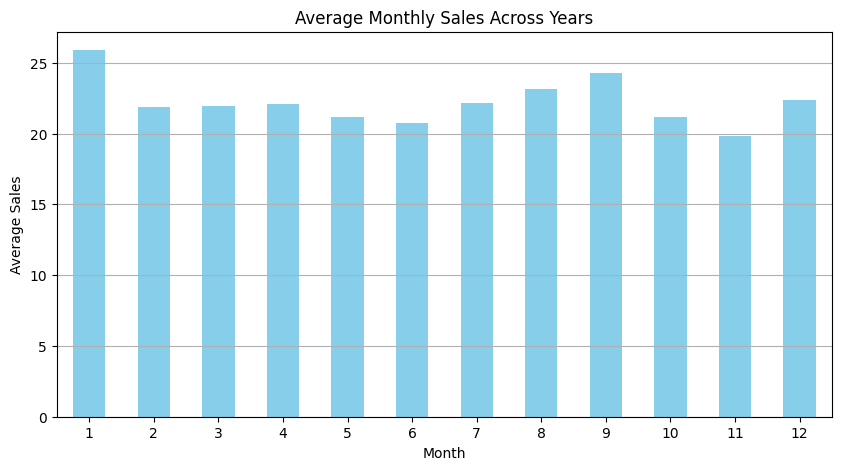

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Make sure InvoiceDate is datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Remove cancelled orders if not already removed
# df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Create Sales column
# df['Sales'] = df['Quantity'] * df['Price']

# Extract month and year
df['Month'] = df['InvoiceDate'].dt.month
df['Year'] = df['InvoiceDate'].dt.year

# Group by month (across years) and calculate average sales per month
monthly_avg_sales = df.groupby('Month')['Sales'].mean()

print(monthly_avg_sales)

# Plot average monthly sales
plt.figure(figsize=(10,5))
monthly_avg_sales.plot(kind='bar', color='skyblue')
plt.title('Average Monthly Sales Across Years')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


# Gonna create bar charts to analyse peak shopping times of DaysOfWeek and HourseOfDay

0        2009-12-01 07:45:00
1        2009-12-01 07:45:00
2        2009-12-01 07:45:00
3        2009-12-01 07:45:00
4        2009-12-01 07:45:00
                 ...        
525456   2010-12-09 20:01:00
525457   2010-12-09 20:01:00
525458   2010-12-09 20:01:00
525459   2010-12-09 20:01:00
525460   2010-12-09 20:01:00
Name: InvoiceDate, Length: 400947, dtype: datetime64[ns]

Day of Week:
 0         1
1         1
2         1
3         1
4         1
         ..
525456    3
525457    3
525458    3
525459    3
525460    3
Name: DayOfWeek, Length: 400947, dtype: int32

Hour of Day:
 0          7
1          7
2          7
3          7
4          7
          ..
525456    20
525457    20
525458    20
525459    20
525460    20
Name: HourOfDay, Length: 400947, dtype: int32


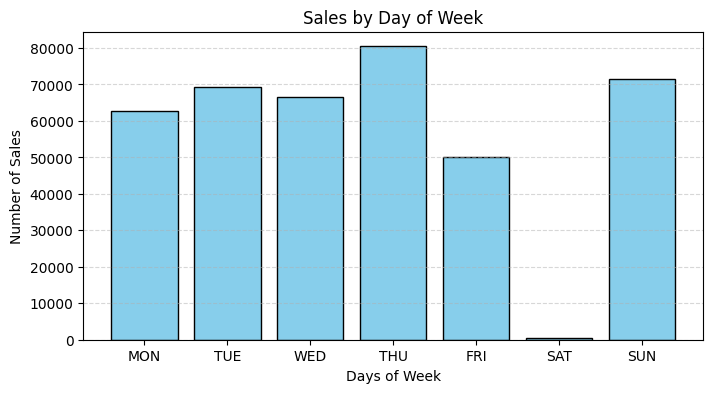

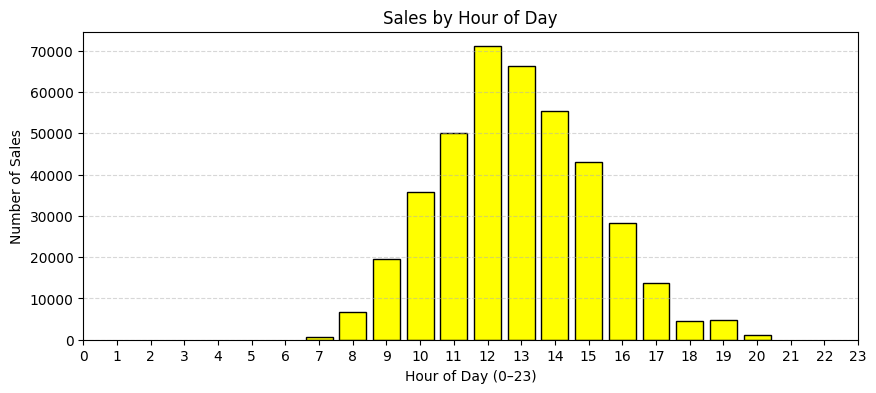

In [11]:
# Convert to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Extract day of week & hour
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek  
df['HourOfDay'] = df['InvoiceDate'].dt.hour

# just a pring to get an idea about dates and datas
print(df['InvoiceDate'])
print("\nDay of Week:\n", df['DayOfWeek'])
print("\nHour of Day:\n", df['HourOfDay'])

# Grouping week days as sales
sales_by_day = df.groupby('DayOfWeek')['InvoiceDate'].count()

# Grouping hours as sales
sales_by_hour = df.groupby('HourOfDay')['InvoiceDate'].count()

# Sales by Day chart
plt.figure(figsize=(8, 4))
plt.bar(sales_by_day.index, sales_by_day.values, color='skyblue', edgecolor='black')
plt.title("Sales by Day of Week")
plt.xlabel("Days of Week")
plt.ylabel("Number of Sales")
plt.xticks(range(7), ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Sales by Hour chart
plt.figure(figsize=(10, 4))
plt.bar(sales_by_hour.index, sales_by_hour.values, color='yellow', edgecolor='black')
plt.title("Sales by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Sales")
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


# Gonna Analyse Top 10 countries by total sales revenue

In [12]:
# print(df['Country'])

total_sales_revenue_of_each_country = df.groupby('Country')['TotalPrice'].sum()

print("Total Sales Revenue Of Each Country : ",total_sales_revenue_of_each_country)

print()
print()

top_10_countries_by_high_sales_revenue = total_sales_revenue_of_each_country.sort_values(ascending=False).head(10)

print("Top 10 Countries with high sales revenue", top_10_countries_by_high_sales_revenue)




Total Sales Revenue Of Each Country :  Country
Australia                 31446.800
Austria                   13414.330
Bahrain                     805.970
Belgium                   24537.580
Brazil                      268.270
Canada                     1216.660
Channel Islands           24546.320
Cyprus                    11347.100
Denmark                   50906.850
EIRE                     356041.860
Finland                    7379.460
France                   146107.070
Germany                  202025.391
Greece                    14335.670
Iceland                    1323.320
Israel                     3199.400
Italy                     15052.730
Japan                      9722.020
Korea                      1118.510
Lithuania                  4892.680
Malta                      5373.500
Netherlands              268784.350
Nigeria                     140.390
Norway                    23944.180
Poland                     3567.800
Portugal                  23843.460
RSA              

# They ask for, out of all the money they made from all countries, which percentage they made in uk alone vs which percentage they made from all the other countries(sum of other country's money except uk)

In [13]:
total_money_they_made_in_uk = df[df['Country'] == 'United Kingdom']['TotalPrice'].sum()

print("How much money they made in UK:", total_money_they_made_in_uk)

# Counting how much mony they made in other countries except in uk

total_money_they_made_in_other_countries = df[df['Country'] != 'United Kingdom']['TotalPrice'].sum()

print("How much money they made in other countries except uk : ", total_money_they_made_in_other_countries)

# calculate percentage of uk

# printing saled item count in uk

total_item_count_in_uk = df[df['Country'] == 'United Kingdom']['Quantity'].sum()

print("Total Item Count In Uk : ", total_item_count_in_uk)

total_item_count_in_other_countries_excep_uk = df[df['Country'] != 'United Kingdom']['Quantity'].sum()

print("Total Item Count In Other Countries Except UK : ", total_item_count_in_other_countries_excep_uk)

# Counting The Percentage

percentage_of_uk_sales = total_money_they_made_in_uk / total_item_count_in_uk

percentage_of_other_country_sales = total_money_they_made_in_other_countries / total_item_count_in_other_countries_excep_uk

print("Percentage Of Uk Sales : ",percentage_of_uk_sales)
print("Percentage of other country sales except uk : ", percentage_of_other_country_sales)




How much money they made in UK: 7381644.432999999
How much money they made in other countries except uk :  1416589.311
Total Item Count In Uk :  4430926
Total Item Count In Other Countries Except UK :  1089522
Percentage Of Uk Sales :  1.665937195295069
Percentage of other country sales except uk :  1.3001933976551185


# Creating bar chart to visualize sales revenue by country

Country
United Kingdom    7381644.433
EIRE               356041.860
Netherlands        268784.350
Germany            202025.391
France             146107.070
Sweden              53147.990
Denmark             50906.850
Spain               47568.650
Switzerland         43921.390
Australia           31446.800
Name: TotalPrice, dtype: float64


Text(0, 0.5, 'countries')

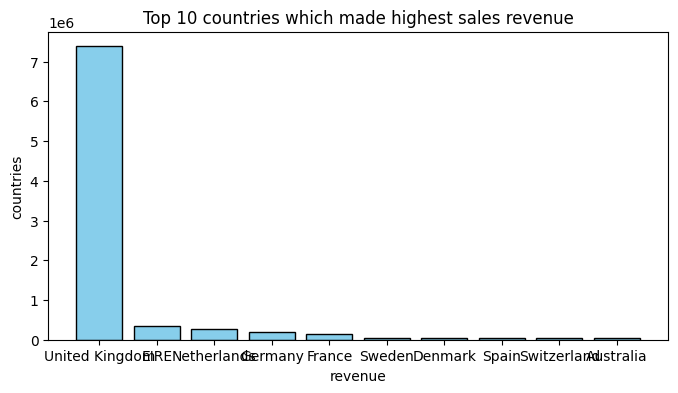

In [14]:
print(top_10_countries_by_high_sales_revenue)

plt.figure(figsize=(8, 4))
plt.bar(top_10_countries_by_high_sales_revenue.index, top_10_countries_by_high_sales_revenue.values, color='skyblue', edgecolor='black')
plt.title("Top 10 countries which made highest sales revenue")
plt.xlabel("revenue")
plt.ylabel("countries")


# Basically gonna anlyse about product perfomance in 2 ways
# Top 10 products by quantity sold
# Top 10 products by total revenue

In [15]:
# Top 10 products by quantity
top_qty = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10).reset_index()

print("Quantity Of Top 10 Products Have Been Sold!")
print()
top_qty.columns = ['Product', 'Total Quantity Sold']
print(top_qty)

print()
print()

# Top 10 products by revenue
top_revenue = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10).reset_index()

print("Total Revenue Of Top 10 Products Have Been Sold!")
print()
top_revenue.columns = ['Product', 'Total Revenue']
print(top_revenue)


Quantity Of Top 10 Products Have Been Sold!

                              Product  Total Quantity Sold
0  WHITE HANGING HEART T-LIGHT HOLDER                56814
1   WORLD WAR 2 GLIDERS ASSTD DESIGNS                54610
2                 BROCADE RING PURSE                 48166
3    PACK OF 72 RETRO SPOT CAKE CASES                45129
4       ASSORTED COLOUR BIRD ORNAMENT                44431
5         60 TEATIME FAIRY CAKE CASES                35656
6  PACK OF 60 PINK PAISLEY CAKE CASES                30871
7             JUMBO BAG RED RETROSPOT                29519
8                SMALL POPCORN HOLDER                25703
9  BLACK AND WHITE PAISLEY FLOWER MUG                25685


Total Revenue Of Top 10 Products Have Been Sold!

                               Product  Total Revenue
0   WHITE HANGING HEART T-LIGHT HOLDER      151339.16
1             REGENCY CAKESTAND 3 TIER      143727.60
2                               Manual       98531.99
3        ASSORTED COLOUR BIRD ORNAMENT

# Phase 2 > 3 > last point says to explain, basically its a discussion............


# Gonna Start RFM Thinggggggggggggg.........!!!!!!

In [16]:
# creating a new dataframe
import pandas as pd

df = pd.read_csv("../UniqueGiftsLTDProject/online_retail_II_full.csv")
df.head()

# removing duplicates of customers by CustomerID

df_unique_customers = df.drop_duplicates(subset="Customer ID")
df_unique_customers.head()

# convers invoice date to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# finding the most recent date to get the snapshot date
most_recent = df['InvoiceDate'].max()
print("The most recent invoice date is ", most_recent) # 2010-12-09 20:01:00

snapshot_date = pd.to_datetime("2010-12-10")
# snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

last_date_each_customer_purchase_an_item = df.groupby('Customer ID')['InvoiceDate'].max()
last_date_each_customer_purchase_an_item.head()

# Calculating Recency
recency = snapshot_date - last_date_each_customer_purchase_an_item
recency.head()
recency_days = recency.dt.days
recency_days.head()






The most recent invoice date is  2010-12-09 20:01:00


Customer ID
12346.0    66
12347.0     2
12348.0    73
12349.0    42
12351.0    10
Name: InvoiceDate, dtype: int64

In [17]:
# Calculating Frequency

# print(df.columns)

frequancy = df.groupby('Customer ID')['Invoice'].nunique()
frequancy.head()



Customer ID
12346.0    15
12347.0     2
12348.0     1
12349.0     4
12351.0     1
Name: Invoice, dtype: int64

In [18]:
# Calculating Moneytary

# Creating TotalPrice column
df['TotalPrice'] = df['Price'] * df['Quantity']

monetary = df.groupby('Customer ID')['TotalPrice'].sum()

monetary.head()




Customer ID
12346.0     -64.68
12347.0    1323.32
12348.0     222.16
12349.0    2646.99
12351.0     300.93
Name: TotalPrice, dtype: float64

In [29]:
rfm = pd.DataFrame({
    'Recency' : recency,
    'Frequency' : frequancy,
    'Monetary' : monetary
})

rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,66 days 07:27:00,15,-64.68
12347.0,2 days 09:03:00,2,1323.32
12348.0,73 days 09:01:00,1,222.16
12349.0,42 days 15:37:00,4,2646.99
12351.0,10 days 08:37:00,1,300.93


In [55]:
# Dividing customers into five equal sized groups

# According to Recency
rfm['Recency_Quintile'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
# rfm['Recency_Quintile'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1], duplicates='drop').astype(int)

print(rfm['Recency'].head())
print(rfm['Recency_Quintile'].head())

print()

# According to Monettory

rfm['MOnetary_Quintile'] = pd.qcut(rfm['Monetary'], 5, labels=[5, 4, 3, 2, 1]).astype(int)

print(rfm['MOnetary_Quintile'].head())

# # According to Frequency
# rfm['Frequency_Quintile'] =  pd.qcut(rfm['Frequency'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# print(rfm['Frequency_Quintile'].head())



Customer ID
12346.0    3
12347.0    1
12348.0    4
12349.0    3
12351.0    1
Name: Recency, dtype: int64
Customer ID
12346.0    3
12347.0    5
12348.0    2
12349.0    3
12351.0    5
Name: Recency_Quintile, dtype: int64

Customer ID
12346.0    5
12347.0    2
12348.0    5
12349.0    1
12351.0    4
Name: MOnetary_Quintile, dtype: int64


In [27]:
import pandas as pd

# Example data: 10 customers
data = pd.DataFrame({
    'CustomerID': range(1, 11),
    'Recency': [2, 5, 10, 1, 20, 30, 25, 5, 2, 15],
    'Frequency': [1, 3, 2, 1, 5, 3, 2, 1, 4, 5],
    'Monetary': [100, 300, 150, 80, 500, 350, 200, 90, 400, 450]
})

# Recency: smaller = better → reverse labels
data['R'] = pd.qcut(data['Recency'], 5, labels=[5,4,3,2,1], duplicates='drop').astype(int)

# Frequency: bigger = better → adjust labels to actual number of bins
freq_bins = pd.qcut(data['Frequency'], 5, duplicates='drop')
num_bins_freq = len(freq_bins.cat.categories)
data['F'] = pd.qcut(data['Frequency'], num_bins_freq, labels=range(1, num_bins_freq+1)).astype(int)

# Monetary: bigger = better → adjust labels to actual number of bins
mon_bins = pd.qcut(data['Monetary'], 5, duplicates='drop')
num_bins_mon = len(mon_bins.cat.categories)
data['M'] = pd.qcut(data['Monetary'], num_bins_mon, labels=range(1, num_bins_mon+1)).astype(int)

# Optional: RFM score
data['RFM_Score'] = data['R'] + data['F'] + data['M']

print(data)


   CustomerID  Recency  Frequency  Monetary  R  F  M  RFM_Score
0           1        2          1       100  5  1  2          8
1           2        5          3       300  4  3  3         10
2           3       10          2       150  3  2  2          7
3           4        1          1        80  5  1  1          7
4           5       20          5       500  2  4  5         11
5           6       30          3       350  1  3  4          8
6           7       25          2       200  1  2  3          6
7           8        5          1        90  4  1  1          6
8           9        2          4       400  5  4  4         13
9          10       15          5       450  2  4  5         11
